In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts 
import seaborn as sns
sns.set()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
raw_csv_data = pd.read_csv("Index2018.csv") 
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

In [ ]:
df_comp['market_value']=df_comp.ftse

In [ ]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [ ]:
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(4)
    return p

Dickey Fuller test to check stationarity

In [ ]:
#dickeyfuller test to check for stationarity
res =  sts.adfuller(df.market_value)
print("pvalue is ",round(res[1],2)," therefore the time series of prices are not stationary")

pvalue is  0.33  therefore the time series of prices are not stationary


check return between previous and current period

In [ ]:
#use returns instead of prices, return is the percentage change
df['returns'] = df.market_value.pct_change(1).mul(100)
df = df.iloc[1:]

#perform dickeyfuller test on returns to check for stationarity
sts.adfuller(df.returns)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(-12.770265719497248,
 7.798058336037938e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '10%': -2.5670785949998973,
  '5%': -2.8621197374408225},
 15696.7672456975)

In [ ]:
res = sts.adfuller(df.returns)
print("pvalue is ",round(res[1],2)," therefore the time series of returns are stationary")

pvalue is  0.0  therefore the time series of returns are stationary


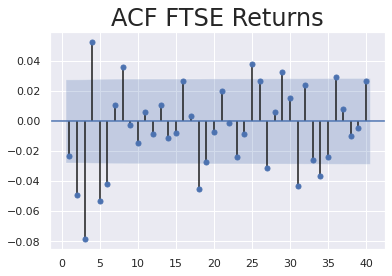

In [ ]:
sgt.plot_acf(df.returns, lags=40, zero = False)
plt.title("ACF FTSE Returns", size=24)
plt.show()

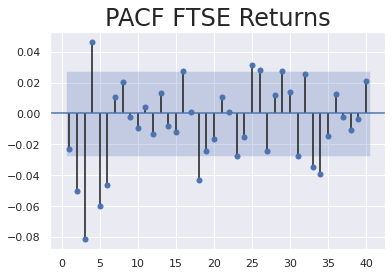

In [ ]:
sgt.plot_pacf(df.returns, lags = 40, zero = False, method = ('ols'))
plt.title("PACF FTSE Returns", size=24)
plt.show()

AR(1) model

In [68]:
#AR(1) model
model_ret_ar_1 = ARMA(df.returns, order = (1,0))
results_ret_ar_1 = model_ret_ar_1.fit()
print("Variables        pvalues")
if(any(i >0.05 for i in results_ret_ar_1.pvalues)):
  print(round(results_ret_ar_1.pvalues,3))

Variables        pvalues
const            0.247
ar.L1.returns    0.103
dtype: float64


In [69]:
#AR(2) model
model_ret_ar_2 = ARMA(df.returns, order = (2,0))
results_ret_ar_2 = model_ret_ar_2.fit()
print("Variables        pvalues")
if(any(i >0.05 for i in results_ret_ar_2.pvalues)):
  print(round(results_ret_ar_2.pvalues,3))
print("LLR test        ",LLR_test(results_ret_ar_1, results_ret_ar_2))

Variables        pvalues
const            0.222
ar.L1.returns    0.086
ar.L2.returns    0.000
dtype: float64
LLR test         0.0004


In [ ]:
#AR(3) model
model_ret_ar_3 = ARMA(df.returns, order = (3,0))
results_ret_ar_3 = model_ret_ar_3.fit()
print("Variables        pvalues")
if(any(i >0.05 for i in results_ret_ar_3.pvalues)):
  print(round(results_ret_ar_3.pvalues,3))
print("LLR test        ",LLR_test(results_ret_ar_2, results_ret_ar_3))

Variables        pvalues
const            0.184
ar.L1.returns    0.044
ar.L2.returns    0.000
ar.L3.returns    0.000
dtype: float64
LLR test         0.0


In [ ]:
#AR(7) model
model_ret_ar_6 = ARMA(df.returns, order = (6,0))
results_ret_ar_6 = model_ret_ar_6.fit()
model_ret_ar_7 = ARMA(df.returns, order = (7,0))
results_ret_ar_7 = model_ret_ar_7.fit()
print("Variables        pvalues")
if(any(i >0.05 for i in results_ret_ar_7.pvalues)):
  print(round(results_ret_ar_7.pvalues,7))
print("LLR test        ",LLR_test(results_ret_ar_6, results_ret_ar_7))

Variables        pvalues
const            0.161990
ar.L1.returns    0.088827
ar.L2.returns    0.000252
ar.L3.returns    0.000000
ar.L4.returns    0.002192
ar.L5.returns    0.000021
ar.L6.returns    0.001039
ar.L7.returns    0.440316
dtype: float64
LLR test         0.4403


Same process with normalized data

In [ ]:
#normalization of prices
benchmark = df.market_value.iloc[0]
df['norm'] = df.market_value.div(benchmark).mul(100)
res = sts.adfuller(df.norm)
if(res[1]>0.05):
  print("non stationarity for prices")
else:
  print("stationarity  for prices")

non stationarity for prices


In [ ]:
#normalize returns
bench_ret = df.returns.iloc[0]
df['norm_ret'] = df.returns.div(bench_ret).mul(100)
res=sts.adfuller(df.norm_ret)
if(res[1]>0.05):
  print("non stationarity for returns")
else:
  print("stationarity  for returns")

stationarity  for returns


In [ ]:
model_norm_ret_ar_1 = ARMA(df.norm_ret, order=(1,0))
results_norm_ret_ar_1 = model_norm_ret_ar_1.fit()
print("Variables        pvalues")
if(any(i >0.05 for i in results_norm_ret_ar_1.pvalues)):
  print(round(results_norm_ret_ar_1.pvalues,3))

Variables        pvalues
const             0.247
ar.L1.norm_ret    0.103
dtype: float64


In [ ]:
model_norm_ret_ar_2 = ARMA(df.norm_ret, order=(2,0))
results_norm_ret_ar_2 = model_norm_ret_ar_2.fit()
print("Variables        pvalues")
if(any(i >0.05 for i in results_norm_ret_ar_2.pvalues)):
  print(round(results_norm_ret_ar_2.pvalues,3))
print("LLR test        ",LLR_test(results_ret_ar_1, results_ret_ar_2))

Variables        pvalues
const             0.223
ar.L1.norm_ret    0.086
ar.L2.norm_ret    0.000
dtype: float64
LLR test         0.0004


In [ ]:
model_norm_ret_ar_6 = ARMA(df.norm_ret, order=(6,0))
results_norm_ret_ar_6 = model_norm_ret_ar_6.fit()
model_norm_ret_ar_7 = ARMA(df.norm_ret, order=(7,0))
results_norm_ret_ar_7 = model_norm_ret_ar_7.fit()
print("Variables        pvalues")
if(any(i >0.05 for i in results_norm_ret_ar_7.pvalues)):
  print(round(results_norm_ret_ar_7.pvalues,3))
print("LLR test        ",LLR_test(results_ret_ar_6, results_ret_ar_7))

Variables        pvalues
const             0.165
ar.L1.norm_ret    0.089
ar.L2.norm_ret    0.000
ar.L3.norm_ret    0.000
ar.L4.norm_ret    0.002
ar.L5.norm_ret    0.000
ar.L6.norm_ret    0.001
ar.L7.norm_ret    0.440
dtype: float64
LLR test         0.4403


model for lag 6 shall be selected 

##Residuals for the normalized values

In [ ]:
df['res_ret'] = results_ret_ar_6.resid
print("mean is ",df.res_ret.mean())
print("variance is ",df.res_ret.var())
print("pvalue is ",sts.adfuller(df.res_ret)[1])

mean is  -5.372412302788232e-05
variance is  1.3559802110696517
pvalue is  0.0


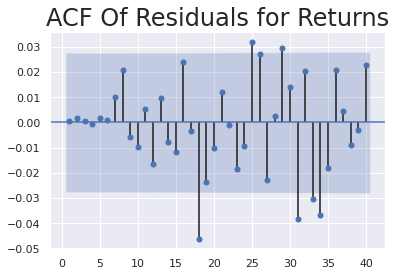

In [ ]:
sgt.plot_acf(df.res_ret, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

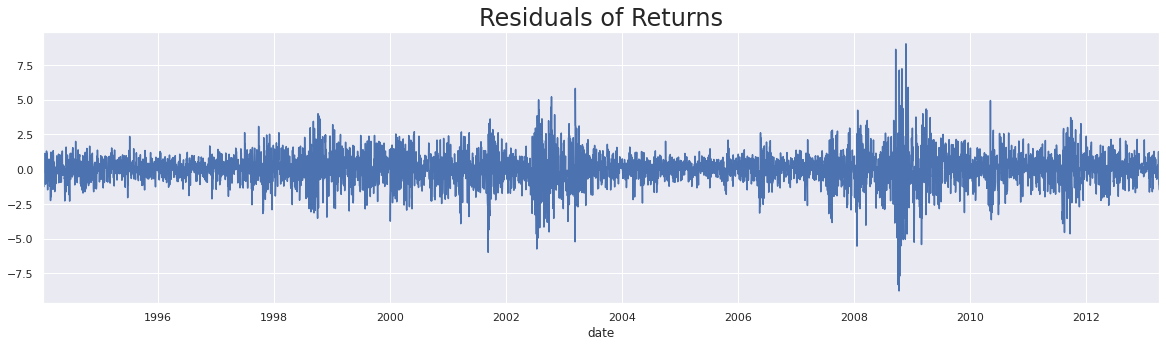

In [ ]:
df.res_ret.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()